<a href="https://www.kaggle.com/code/srsses/image-segmentation-unet?scriptVersionId=156349516" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.7/394.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.0/462.0 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: grpcio
    Found exi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


Text(0.5, 1.0, 'Segmentation')

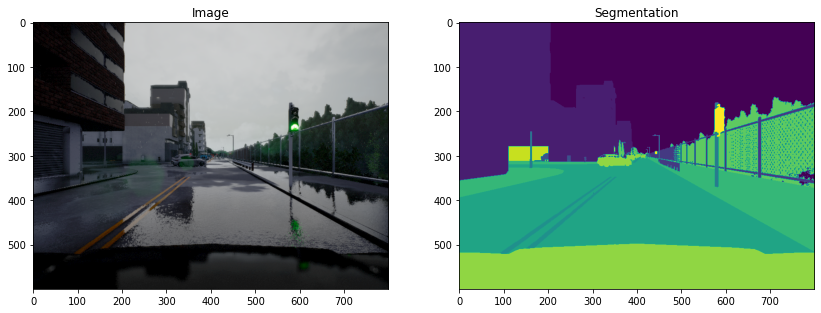

In [1]:
!pip install --upgrade tensorflow==2.4

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline
image_path = ('/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/')
mask_path = ('/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/')
test_path = ('/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraRGB/')
test_mask = ('/kaggle/input/lyft-udacity-challenge/dataB/dataB/CameraSeg/')
image_list = sorted(os.listdir(image_path))
mask_list = sorted(os.listdir(mask_path))
test_image_list = sorted(os.listdir(test_path))
test_mask_list = sorted(os.listdir(test_mask))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
test_image_list = [test_path+i for i in test_image_list]
test_mask_list = [test_mask+i for i in test_mask_list]
img = imageio.imread(image_list[12])
mask = imageio.imread(mask_list[12])
    #mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:,:,0])
arr[1].set_title('Segmentation')

In [2]:
mask.shape

(600, 800, 3)

In [3]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)


image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)


In [4]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
test_image_ds = test_dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
test_processed_image_ds = test_image_ds.map(preprocess)

In [5]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)   
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [6]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [7]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [8]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

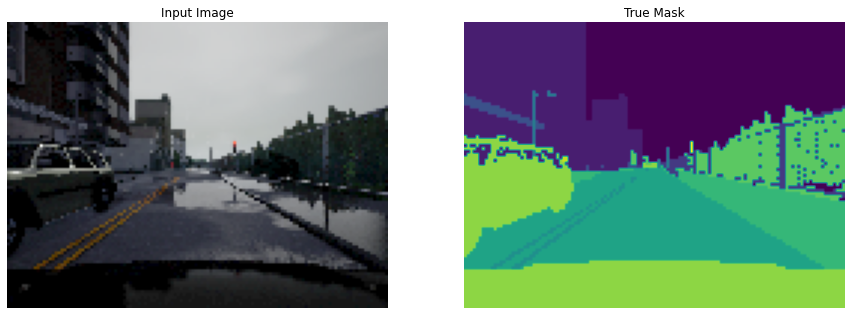

In [11]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [12]:
EPOCHS = 20
VAL_SUBSPLITS = 10
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/20
32/32 [==============================] - 36s 459ms/step - loss: 2.9200 - accuracy: 0.1748
Epoch 2/20
32/32 [==============================] - 2s 69ms/step - loss: 1.6461 - accuracy: 0.4401
Epoch 3/20
32/32 [==============================] - 2s 69ms/step - loss: 0.8466 - accuracy: 0.7146
Epoch 4/20
32/32 [==============================] - 2s 69ms/step - loss: 0.6396 - accuracy: 0.7830
Epoch 5/20
32/32 [==============================] - 2s 69ms/step - loss: 0.5740 - accuracy: 0.8061
Epoch 6/20
32/32 [==============================] - 2s 69ms/step - loss: 0.4950 - accuracy: 0.8410
Epoch 7/20
32/32 [==============================] - 2s 69ms/step - loss: 0.4023 - accuracy: 0.8745
Epoch 8/20
32/32 [==============================] - 2s 69ms/step - loss: 0.3731 - accuracy: 0.8844
Epoch 9/20
32/32 [==============================] - 2s 69ms/step - loss: 0.3225 - acc

In [13]:
tests_dataset = test_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

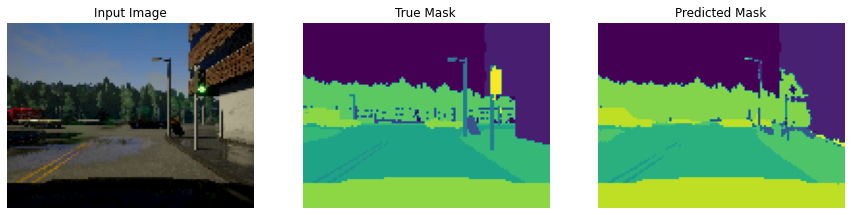

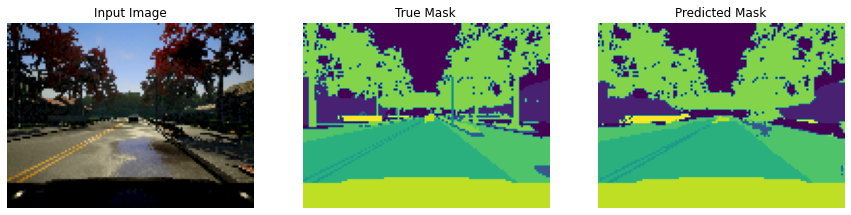

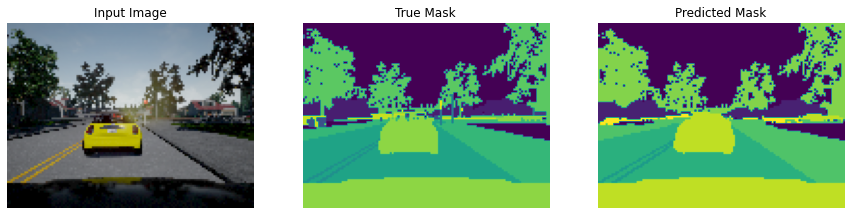

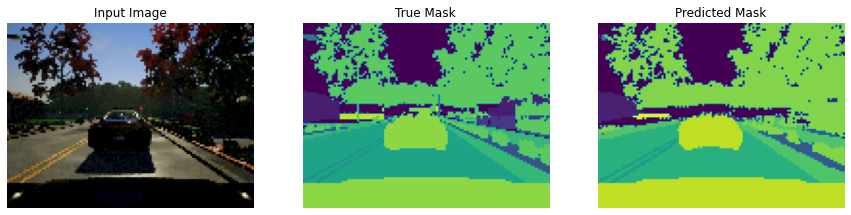

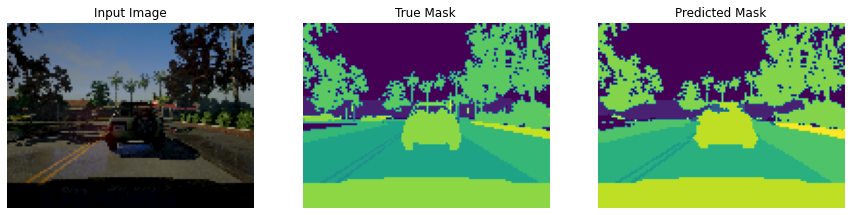

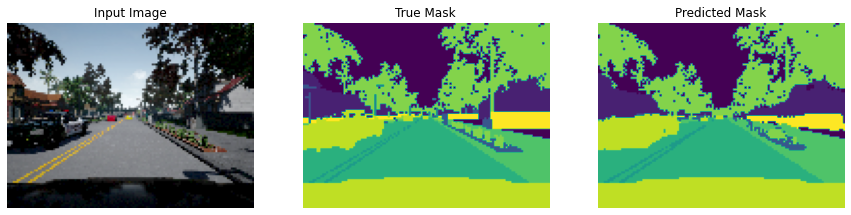

In [15]:
show_predictions(tests_dataset, 6)